# Workshop on Domain-Specific Lanugages for Performance-Portable Weather and Climate Models

## Session 1B: More Basic Concepts

This notebook begins by revisiting the laplacian example from the previous session, this time demonstrating how easily code implemented with GT4Py can be run on an NVIDIA GPU

We first import the necessary packages as before.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gt4py
import gt4py.storage as gt_storage
from gt4py import gtscript
from gt4py.gtscript import Field

### Define the 2D Laplacian stencil:

In [2]:
def laplacian_def(in_field: Field[np.float], out_field: Field[np.float], *, coeff: np.float):
    with computation(PARALLEL), interval(...):
        out_field = coeff * (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])

### Domain Specification

Specify the initial domain sizes: (*n<sub>i</sub>*, *n<sub>j</sub>*, *n<sub>k</sub>*), the number of halo lines in *x* and *y*, *n<sub>halo</sub>*, and the number of times to run each backend, *n<sub>runs</sub>*.

In [3]:
ni, nj, nk = 24, 24, 80
nhalo = 3
nruns = 5

### Generate Scalability Data

Here we define the `origin`, `domain`, data `shape`, and `backends`. The `gtx86` backend is replaced with `gtcuda` to generate CUDA code. The inner loop executes the stencil `nruns` times for each backend, with the horizontal domain size doubled at each iteration to generate scalability timings.

In [7]:
origin = (nhalo, nhalo, 0)
backends = ["numpy", "gtmc", "gtcuda"]

timings = dict()
sizes = dict()

for backend in backends:
    ni = nj = 24
    sizes[backend] = []
    timings[backend] = []    

    for n in range(0, nruns):
        print(f"Running with {backend} backend ({n})...")
        
        domain = (ni, nj, nk)
        shape = (ni + 2 * nhalo, nj + 2 * nhalo, nk)
        
        rand_data = np.random.randn(*shape)        
        in_field = gt_storage.from_array(rand_data, backend, origin, shape, dtype=np.float64)        
        out_field = gt_storage.zeros(backend, origin, shape, np.float64)        
        exec_info = {}

        laplacian = gtscript.stencil(backend, laplacian_def)
        laplacian(in_field, out_field, coeff=0.125, origin=origin, domain=domain, exec_info=exec_info)  # , validate_args=False)
        
        call_time = (exec_info['call_end_time'] - exec_info['call_start_time']) * 1000.
        run_time = (exec_info['run_end_time'] - exec_info['run_start_time']) * 1000.        
        
        timings[backend].append(run_time)
        sizes[backend].append(ni)

        ni *= 2
        nj = ni

Running with numpy backend (0)...
Running with numpy backend (1)...
Running with numpy backend (2)...
Running with numpy backend (3)...
Running with numpy backend (4)...
Running with gtmc backend (0)...
Running with gtmc backend (1)...
Running with gtmc backend (2)...
Running with gtmc backend (3)...
Running with gtmc backend (4)...
Running with gtcuda backend (0)...
Running with gtcuda backend (1)...
Running with gtcuda backend (2)...
Running with gtcuda backend (3)...
Running with gtcuda backend (4)...


### Plot the Performance

The generated timing data can be visualized using `matplotlib`. The *y*-axis is in log scale to highlight the performance improvement from `numpy` to an optimized CPU backend (`gtmc`), and finally to optimized GPU code (`gtcuda`).

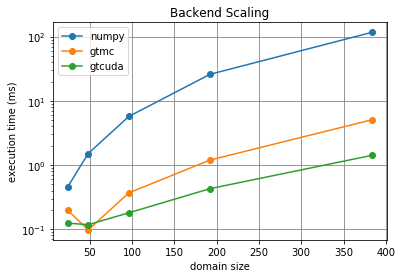

In [10]:
for backend in backends:
    plt.plot(sizes[backend], timings[backend], "-o", label=backend)

plt.title("Backend Scaling")
plt.grid(color="gray", linestyle='-')
plt.legend()
plt.xlabel("domain size")
plt.ylabel("execution time (ms)")
plt.yscale("log")

plt.show()

### Inspect the Generated Code



<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    (Hint: Make sure that when you modify code you retain the original code by commenting it out so that you undo any of the modifications you do.)
    <ol>
        <li style="margin-bottom: 10px">Extend the `laplacian` stencil to be a laplacian(laplacian(*)) by introducing a temporary field.</li>
        <li style="margin-bottom: 10px">Replace the redundant code with `gtscript.function`.</li>
        <li style="margin-bottom: 10px">Replace the redundant code with `gtscript.function`.</li>
    </ol>
</div>

In [14]:
# SOLUTION 1:
@gtscript.stencil(backend="numpy")
def diffusion_def1(in_field: Field[np.float], out_field: Field[np.float], *, coeff: np.float):
    with computation(PARALLEL), interval(...):
        tmp_field = coeff * (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])
        out_field = coeff * (-4. * tmp_field +
            tmp_field[1, 0, 0] + tmp_field[-1, 0, 0] + 
            tmp_field[0, 1, 0] + tmp_field[0, -1, 0])

In [15]:
# SOLUTION 2:
@gtscript.function
def laplacian(in_field: Field[np.float], coeff: np.float):
    return coeff * (-4. * in_field +
           in_field[1, 0, 0] + in_field[-1, 0, 0] + 
           in_field[0, 1, 0] + in_field[0, -1, 0])

@gtscript.stencil(backend="numpy")
def diffusion_def2(in_field: Field[np.float], out_field: Field[np.float], *, coeff: np.float):
    with computation(PARALLEL), interval(...):
        tmp_field = laplacian(in_field, coeff)
        out_field = laplacian(tmp_field, coeff)

In [6]:
itype = np.int
IntFieldK = Field[itype, gtscript.K]
backend = "numpy"


@gtscript.stencil(backend=backend)
def fibonacci(fib: IntFieldK):    
    with computation(FORWARD), interval(2, None):
        fib = fib[0, 0, -2] + fib[0, 0, -1]
        

fib_field = gt_storage.zeros(backend, (0, 0, 0), (1, 1, 64), itype)
fib_field[0, 0, 1] = 1    # base case...

fibonacci(fib_field, origin=(0, 0, 0), domain=(1, 1, 64), validate_args=False)
fib_field

CPUStorage([[[            0,             1,             1,
                          2,             3,             5,
                          8,            13,            21,
                         34,            55,            89,
                        144,           233,           377,
                        610,           987,          1597,
                       2584,          4181,          6765,
                      10946,         17711,         28657,
                      46368,         75025,        121393,
                     196418,        317811,        514229,
                     832040,       1346269,       2178309,
                    3524578,       5702887,       9227465,
                   14930352,      24157817,      39088169,
                   63245986,     102334155,     165580141,
                  267914296,     433494437,     701408733,
                 1134903170,    1836311903,    2971215073,
                 4807526976,    7778742049,   1258626902

In [7]:
backend = "gtmc"
dtype = np.float64
Field3D = Field[dtype]
Field2D = Field[dtype, gtscript.IJ]


@gtscript.stencil(backend=backend)
def parallel_sum(nums: Field3D, sums: Field2D):
    with computation(PARALLEL), interval(...):
        sums += nums
        

in_data = np.fromfunction(lambda i, j, k: np.sin(i) * np.cos(j), (64, 64, 64), dtype=dtype)
nums = gt_storage.from_array(in_data, backend, (0, 0, 0), (64, 64, 64), dtype=dtype)  
sums = gt_storage.zeros(backend, (0, 0, 0), (64, 64, 1), dtype)

parallel_sum(nums, sums, origin=(0, 0, 0), domain=(64, 64, 64), validate_args=False)

sums[:, :, 0]

CPUStorage([[  0.        ,   0.        ,   0.        , ...,   0.        ,
               0.        ,   0.        ],
            [ 53.85414303,  29.09751766, -22.41123126, ..., -13.89984242,
              36.27115105,  53.09461552],
            [ 58.19503532,  31.44291177, -24.21767985, ..., -15.02023382,
              39.1947731 ,  57.37428638],
            ...,
            [-61.83153728, -33.40772217,  25.73099864, ...,  15.95882092,
             -41.64398322, -60.95950124],
            [-47.30756459, -25.56038623,  19.68689335, ...,  12.21015981,
             -31.86198358, -46.64036621],
            [ 10.71076482,   5.78705093,  -4.4572509 , ...,  -2.76446592,
               7.21377682,  10.55970642]])

In [8]:
backend = "gtmc"
dtype = np.float64
itype = np.int32
Field3D = Field[dtype]
IntField2D = Field[itype, gtscript.IJ]


@gtscript.stencil(backend=backend)
def parallel_count(nums: Field3D, counts: IntField2D):
    with computation(PARALLEL), interval(...):
        if nums > 0.0:
            counts += 1
        

in_data = np.fromfunction(lambda i, j, k: np.sin(i) * np.cos(j), (64, 64, 64), dtype=dtype)
nums = gt_storage.from_array(in_data, backend, (0, 0, 0), (64, 64, 64), dtype=dtype)  
counts = gt_storage.zeros(backend, (0, 0, 0), (64, 64, 1), itype)

parallel_count(nums, counts, origin=(0, 0, 0), domain=(64, 64, 64), validate_args=False)

counts[:, :, 0]

CPUStorage([[ 0,  0,  0, ...,  0,  0,  0],
            [64, 64,  0, ...,  0, 64, 64],
            [64, 64,  0, ...,  0, 64, 64],
            ...,
            [ 0,  0, 64, ..., 64,  0,  0],
            [ 0,  0, 64, ..., 64,  0,  0],
            [64, 64,  0, ...,  0, 64, 64]], dtype=int32)

In [9]:
backend = "numpy"
dtype = np.float64
Field3D = Field[dtype]
N = 1024

@gtscript.stencil(backend=backend)
def tridiag_mv_mul(a: Field3D, b: Field3D, c: Field3D, d: Field3D, x: Field3D):
    with computation(PARALLEL):
        with interval(0, 1):
            d = b * x + c * x[0, 0, 1]
        with interval(1, -1):
            d = a * x[0, 0, -1] + b * x + c * x[0, 0, 1]
        with interval(-1, None):
            d = a * x[0, 0, -1] + b * x

@gtscript.stencil(backend=backend)        
def tridiag_solve(a: Field3D, b: Field3D, c: Field3D, d: Field3D, x: Field3D):
    with computation(FORWARD):
        with interval(1, None):
            w = a / b[0, 0, -1]
            b -= w * c[0, 0, -1]
            d -= w * d[0, 0, -1]
    with computation(BACKWARD):
        with interval(-1, None):
            x = d / b
        with interval(0, -1):
            x = (d - c * x[0, 0, 1]) / b


origin = (0, 0, 0)
shape = (1, 1, N)
a = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
b = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
c = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
x0 = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
d = gt_storage.zeros(backend, origin, shape, dtype=dtype)
x1 = gt_storage.zeros(backend, origin, shape, dtype=dtype)

tridiag_mv_mul(a, b, c, d, x0)
tridiag_solve(a, b, c, d, x1)
assert np.allclose(x0, x1)
x1[0, 0, :]

CPUStorage([ 0.32382328, -0.16016521,  0.16984354, ..., -0.26456895,
            -0.33954019, -1.05020013])